In [1]:
### Import Libraries 
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import pandas as pd
from scipy.sparse import hstack
from nltk.stem import PorterStemmer
import string
!pip install scikit-multilearn             ### For installing scikit-multilearn
#import skmultilearn
from skmultilearn.problem_transform import LabelPowerset        # if error in this line this use import skmultilearn first


In [2]:
### Reading csv data files using pandas dataframe 

train = pd.read_csv("/content/train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("/content/test.csv", encoding = "ISO-8859-1")

In [3]:
### Checking nulls in both the datasets

print("Nulls in training dataset",train.isnull().sum())
print("\nNulls in test dataset",test.isnull().sum())

### There are no missing values in both the datasets

Nulls in training dataset id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Nulls in test dataset id              0
comment_text    0
dtype: int64


In [8]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

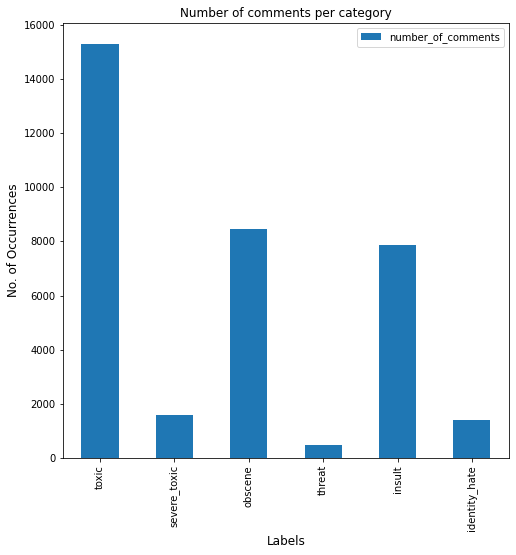

In [9]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


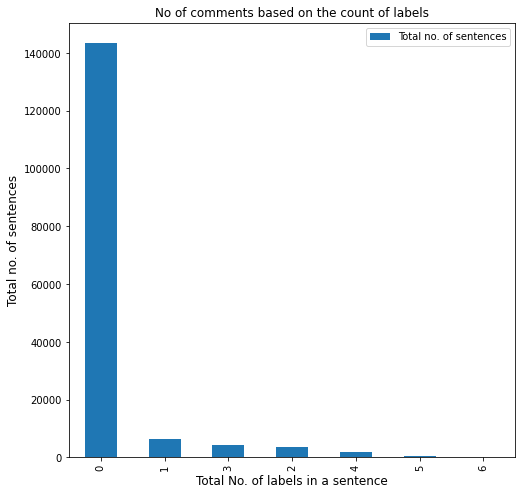

In [10]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

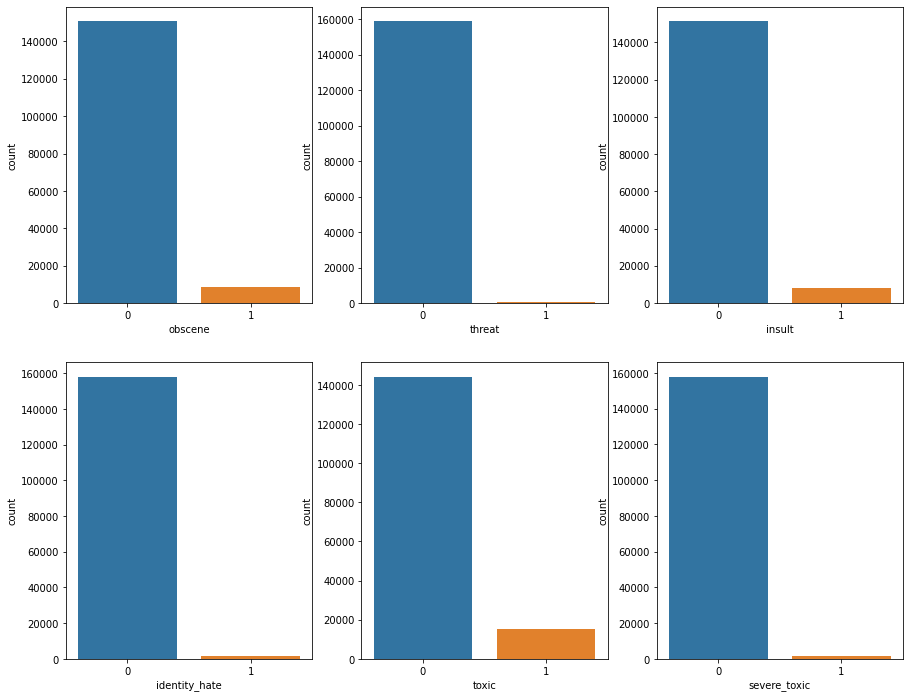

In [11]:
### Visualization 3

### Graph of individual class against the total no. of labelled and unlabelled sentences for the same class

fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

### From this graph it can be concluded that every class(category) is having higher no. of unlabelled sentences(0) as compared
### to labelled sentences(1)

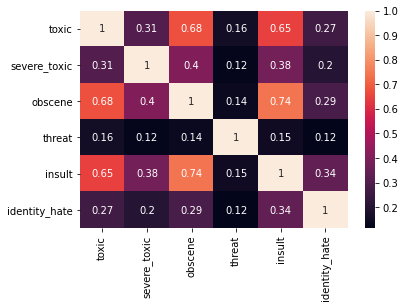

In [12]:
### Visualization 4

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [ ]:
### From visualization we can conclude following things
### 1) A single sentence can have multiple labels (categories)
### 2) Some labels are highely correlated to each other
### 3) This is multi label classification problem 

In [10]:
## I have used stemming NLP operation below. It is taking time. Hence you need to increase the system recursionlimit. Otherwise it will give you an error.
import sys
sys.setrecursionlimit(10**6) 

In [11]:
### Data cleaning/Preparation 

def clean_text(text):
    text = text.lower()
    text = re.sub('\@\w+|\#', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                              ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)                                  ### Remove urls
    text = text.translate(str.maketrans('', '', string.punctuation))                     ### remove punctuations
    tokenized_words = [word for word in text.split() if word not in (stop_words)]         ### Stopwords removal
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in tokenized_words]                                ### Stemming the words
    
    return " ".join(stemmed_words)


train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)


In [12]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]


In [13]:
### create input feature vector using tf-idf. 20000 words are choosen with an ingram range of 1,2. It will consider take unigram and bigram while creating the matrix. 
### word vector will be a combination of unigram as well as bigram.
##I decided to use word vectorizer along with well as character vectorizer in order to get a good robust set of input features. 
### tf-idf is the famous algorithm used to convert the text into numbers. TF-IDF for a word in a document is calculated by multiplying two different metrics.
### Those 2 metrics are term frequency(tf) and inverse document frequency (idf).In term frequency, frequency of a word can be calculated by taking raw count of instances a word appearance in that document. 
### Frequency can be adjusted by adjusting length of a document, or by adjusting the raw frequency of the most frequent word in a document.
### The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.
### So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.
### Multiplying these two numbers results in the TF-IDF score of a word in a document. The higher the score, the more relevant that word is in that particular document.

word_vec = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    max_features=20000)
train_word_features = word_vec.fit_transform(train_data)
test_word_features =  word_vec.fit_transform(test_data)


In [14]:
### This is the character vectorization. 50000 characters are choosen with an ngram range starting from 2 to 6. It will consider all multiple characters starts from length 2
### and extends upto 6

char_vec = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
train_char_features = char_vec.fit_transform(train_data)
test_char_features = char_vec.fit_transform(test_data)

In [15]:
### Stacking the word and character embeddings together

train_final_features = hstack([train_char_features, train_word_features])
test_final_features = hstack([test_char_features, test_word_features])


In [ ]:
### We have our input feature set available. Now we need to select the classification method and we have multilabel multi classification problem. 
### There are multiple approaches which can be used to transform multilabel problem into multiple single-label problems, so that the existing single-label algorithms can be used.
### We can use either OneVsRest strategy. This method falls under Problem transformation methods category.In an “one-to-rest” strategy, we can build multiple independent classifiers and, for an unseen instance, 
### choose the class for which the confidence is maximized. In this method, for every label a classifier is build and predictions are made for that particular label. 
### This method doesn't consider the underlying correlation between the variables. we do have few variables which are highly correlated. 
### Another methods are algorithm adaptation methods. These methods try to address the the problem in its full form. It doesn't try and convert the 
### problem to a simpler problem. Moreover these methods consider the underlying correlation between different variables. I used Label Power set method. It 
### transforms the multilabel problem to multiclass problem with 2^l possible labels(class values). So for every observation all the available multiple classes are assigned.
### It considers label dependency. Our standard ML algorithm calculates the probability distribtuion. I used logistic regression for that. 
### Label Power set method assigns the rankings to the classes based on the probability.  I tried Power set method many times but everytime google collab crashed.
### I tried sampling 60000 rows and tried building model using reduced dataset. Still it crashed. My local system also crashed multipl times. 
### Hence I built model using OneVsRest method which includes logistic regression classifier.


In [16]:
### OneVsRest method using logistic regression - This is the 1st method I tried. 

LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])
categories = list(train_label.columns.values)
x_train, x_test, y_train, y_test = train_test_split(train_final_features, train_label, shuffle = True, random_state = 123)

for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    print("\n")

**Processing toxic comments...**
Test accuracy is 0.9625748878249317


**Processing severe_toxic comments...**
Test accuracy is 0.9903491840673803


**Processing obscene comments...**
Test accuracy is 0.9801468929386108


**Processing threat comments...**
Test accuracy is 0.997443160454215


**Processing insult comments...**
Test accuracy is 0.9730027824430351


**Processing identity_hate comments...**
Test accuracy is 0.9925550848519791




In [ ]:
### label powerset multi-label classifier - This is the reference code which I tried. Due to lack of processing capabilties, it took longer time and google collab
### crashed multiple times. This may or may not work. 


x_train, x_test, y_train, y_test = train_test_split(train_final_features, train_label, shuffle = True, random_state = 123)

# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# training the classifier 
classifier.fit(x_train, y_train)
# making predictions
predictions = classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")


In [ ]:
#### Complete description of classification system using neural networks

## This classification system is built using traditional ML model. I used logistic regression. 

### Process performed in this classification model are mentioned below.
## Reading the dataset using pandas dataframe and checking whether it contains any null observations or not. There are no nulls in this dataset.
## Many people clean the data first and then perform visualizations. I performed visualizations first. 
## I created 4 visualizations. 
## 1st visualization is a Bar graph of total number of comments per label. It is helpful in identifying the total number of comments per label
## 2nd visualization is a Bar graph of Total No. of labels in a sentence against Total no. of sentences. 
## From 2nd visualization we can observe whether a sentence belongs to only one category or many categories. We can say that
## there are many sentences which are not classified(label 0) but many sentences falls under more than 1 category.
## 3rd Visualization is a Graph of individual class against the total no. of labelled and unlabelled sentences for the same class. 
## 4th Visualization is a Correlation graph(matrix) between different variables

## From visualization we can conclude that,  1) A single sentence can have multiple labels (categories).
## 2) Some labels are highely correlated to each other.
## 3) This is multi label classification problem. Hence we can use sigmoid function in the output layer.

### Next part includes cleaning the data. Data cleaning part is performed on the input text. 
## I created a function, which performs below activities: 
## 1) remove punctuations  , 2) removing stopwords , 3) lowercasing the words
## 4) removing the non - alphanumeric characters, 5) removing the extra spaces between words, 6) taking root/leaf of each word by performing stemmatization
## 7) removing urls

### Once we have cleaned the data, next part is creating input feature vectors.  
## Tf-Idf vectorization method is used to create input features. A single input feature is the combination of characters and words.  
## once we have the input features, those features are given to the logistic regression model. 
## OneVsRest method is used to generate logistic regression model. I have added the code for Label Powerset also. OneVsRest helps us to decompose multiple
## labels into single label and helps us in predicting the labelwise accuracy. 
## Accuracy for individual label is as follows: toxic label:0.9625999548793022, severe_toxic comments:0.9903993181761211, obscene comments:0.9801468929386108,
## threat comments:0.9974682275085854, insult comments:0.9731782518236282, identity_hate comments:0.9924297495801269
## Accuracy can be defined as the ability to correctly predict the labels.
